In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_guess, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
from torch.nn import Linear, Sequential, ReLU, LeakyReLU
from torch.optim import Adam

In [3]:
# run only if new data is desired
ode_dim = 3
n_data = 10
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1000)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,2*n_data))

loader = DataLoader(dataset_train,batch_size=32,shuffle=True)

x_text_exact, x_test, y_test, param_test = create_dataset(ode_dim,n_data,128)

dataset = []
for i in range(0,len(x_test)):
    p = param_test[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset.append(to_pyg_data_true(x_test[i],y_test[i],ode_dim,2*n_data))

test_loader = DataLoader(dataset,batch_size=128,shuffle=True)

In [4]:
from torch.nn import Linear, Sequential, LeakyReLU
from torch_geometric.nn import GATConv

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()

        self.gcn1 = GCNConv(in_channels,4*out_channels)
        self.gcn2 = GCNConv(4*out_channels,out_channels)

    def forward(self, data, edge_index):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        x = self.gcn2(x,edge_index=edge_index)
        return torch.nn.functional.leaky_relu(x)

In [5]:
class MLPDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=16):
        super(MLPDecoder, self).__init__()
        # Define the MLP for decoding
        self.mlp = Sequential(
            Linear(2 * embedding_dim, hidden_dim),
            LeakyReLU(),
            Linear(hidden_dim, 1)  # Output a single value (edge weight) for each pair
        )

    def forward(self, z, edge_index):
        # Extract source and target node embeddings based on edge_index
        src_nodes = z[edge_index[0]]  # Shape: (num_edges, embedding_dim)
        tgt_nodes = z[edge_index[1]]  # Shape: (num_edges, embedding_dim)

        # Concatenate source and target embeddings for each pair
        edge_features = torch.cat([src_nodes, tgt_nodes], dim=-1)  # Shape: (num_nodes, num_nodes, 2 * embedding_dim)

        # Pass through MLP to predict edge weights
        edge_weights = self.mlp(edge_features).squeeze(-1)  # Shape: (num_nodes, num_nodes)

        return edge_weights

In [15]:
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_dense_adj

model = GAE(GCNEncoder(2*n_data,30),MLPDecoder(30))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = torch.nn.MSELoss()

train_loss = []

for epoch in range(3000):
    model.train()

    tr_loss = 0
    full_loss = 0
    for data in loader:
        data = data.to(device)
        batch_size = data.batch.max().item()+1
        optimizer.zero_grad()

        z = model.encode(data, data.edge_index)

        recon_part = model.decode(z,data.edge_index)

        loss = criterion(recon_part,data.edge_attr.flatten())

        train_loss.append(loss)
        full_loss += loss

        loss.backward()
        optimizer.step()
        
        tr_loss += loss

        with torch.no_grad():
            latent_embeddings = z.cpu().detach().numpy()
    #train_loss.append(full_loss)
    print(full_loss.item())

for data in dataset_train:
    z = model.encode(data.to(device), data.edge_index)

    recon = model.decode(z,data.edge_index)

    print(recon)

98.71424102783203
97.99836730957031
98.52151489257812
97.16056060791016
96.57830047607422
96.4947738647461
94.84720611572266
96.36201477050781
95.20940399169922
93.76192474365234
90.58360290527344
90.362060546875
88.4630126953125
89.28107452392578
87.25070190429688
87.21977233886719
83.70292663574219
87.18614959716797
84.36689758300781
86.10087585449219
85.68281555175781
86.51419830322266
84.80475616455078
82.5472183227539
82.30928039550781
81.5785140991211
84.2580337524414
82.39037322998047
81.3564453125
80.87857818603516
81.62452697753906
81.98738861083984
82.7276611328125
81.81373596191406
80.9827880859375
82.6158218383789
80.37626647949219
81.31950378417969
81.5989761352539
79.70035552978516
80.99111938476562
81.68170166015625
78.72679138183594
79.7642822265625
80.1469497680664
80.79026794433594
79.55146026611328
78.2912826538086
78.13529968261719
77.76949310302734
77.88239288330078
78.49568939208984
78.93412017822266
77.46538543701172
78.33731842041016
77.63294982910156
77.4749221

KeyboardInterrupt: 

(3000, 30)


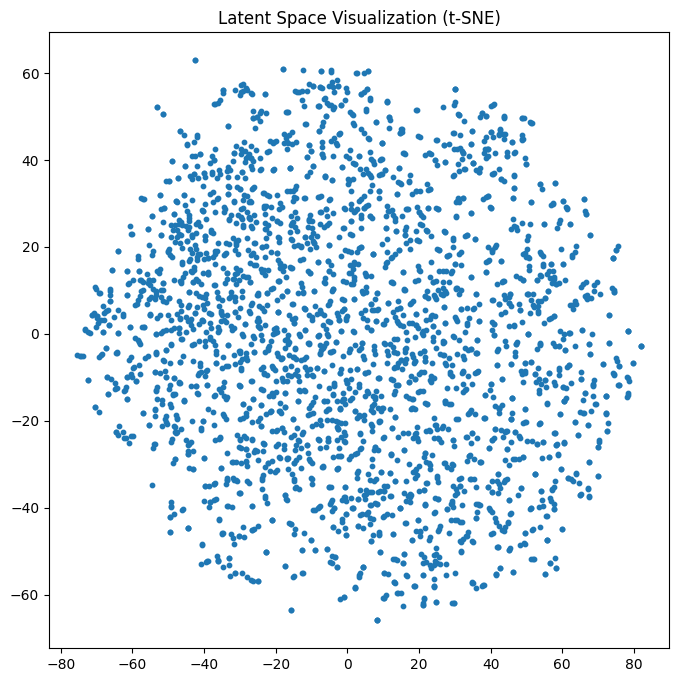

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_embeddings =  torch.tensor(1)

for data in loader:
        data = data.to(device)
        z = model.encode(data, data.edge_index)

        with torch.no_grad():
            if len(latent_embeddings.shape) == 0:
                 latent_embeddings = z
            else:
                latent_embeddings = torch.cat((latent_embeddings,z))

latent_embeddings = latent_embeddings.cpu().detach().numpy()
print(latent_embeddings.shape)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10)
plt.title("Latent Space Visualization (t-SNE)")
plt.show()

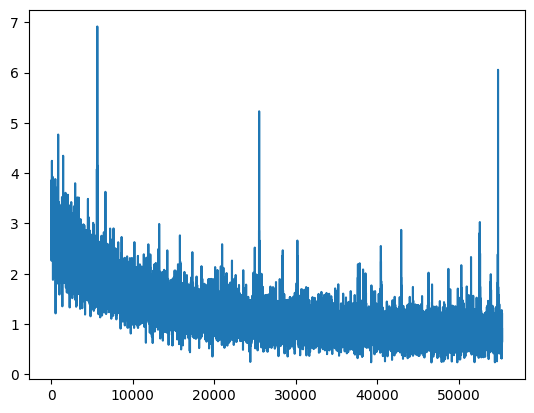

In [17]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i].to('cpu').detach().numpy() for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [19]:
def get_adjacency(W):
        values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
        treshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
        W_bool_activation = (W >= torch.exp(treshold)).double()
        W_bool_repr = (W <= -torch.exp(treshold)).double()
        A = W_bool_activation-W_bool_repr
        return A

x_val_exact, x_val, y_val, param_val = create_dataset(ode_dim,n_data,100)

val_dataset = []
param_list = []

for i in range(0,len(x_val)):
    p = param_val[i]
    param_vec = torch.cat((p.Win.flatten(), p.Wout.flatten(), p.bin, p.bout, p.gamma)).numpy()
    param_list.append(param_vec)
    val_dataset.append(to_pyg_data_true(x_val[i],y_val[i],ode_dim,2*n_data))

val_loader = DataLoader(val_dataset,batch_size=1)

correct = 0
init_correct = 0
total = 0
elem_wise = 0
elem_wise_init = 0
elems_total = 0

changed = 0
fixed = 0
destroyed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k = 0
for batch in val_loader:
    batch = batch.to(device)
    z = model.encode(batch, batch.edge_index)
    
    recon = model.decode(z,batch.edge_index)
    Ahat = recon.flatten()

    print(batch.edge_attr)
    print(Ahat)

    # Ahat = get_adjacency(model(batch)).t()[0]
    A = get_adjacency(batch.edge_attr)
    Ahat = get_adjacency(Ahat)
    print(Ahat)
    print(A)
    if sum(abs(Ahat-A)) < 0.001:
            correct = correct+1
    total = total + 1

    for i in range(0,len(A)):

        if abs(Ahat[i]-A[i]) < 0.001:
             elem_wise += 1   
            
        elems_total += 1

print(correct/total)
print(elem_wise/elems_total)

tensor([-1.0998,  2.1032, -1.2189,  1.0064], device='cuda:0')
tensor([-1.5225,  2.6499,  1.3018, -1.7433], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([0., 1., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([0., 1., 0., 0.], device='cuda:0', dtype=torch.float64)
tensor([ 1.1464, -2.6089,  1.9930, -2.1616], device='cuda:0')
tensor([1.4117, 0.0303, 0.5663, 0.7175], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([1., 0., 1., 1.], device='cuda:0', dtype=torch.float64)
tensor([ 0., -1.,  1., -1.], device='cuda:0', dtype=torch.float64)
tensor([-0.6228, -2.5626,  2.6609, -0.9009,  3.8270], device='cuda:0')
tensor([ 1.0333, -0.2641,  0.0520, -1.5469, -0.3805], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([ 1., -1.,  0., -1., -1.], device='cuda:0', dtype=torch.float64)
tensor([ 0., -1.,  1.,  0.,  1.], device='cuda:0', dtype=torch.float64)
tensor([-1.3723,  3.0454,  0.4111,  0.7095], device='cuda:0')
tensor([-1.8548, -2.0950, -1.5434, -2.4211], de